In [75]:
import fiona
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
import json
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import googlemaps
import time
from IPython.core.display import display, HTML
from IPython.display import IFrame
import re
from multiprocessing.dummy import Pool
from multiprocessing import cpu_count, freeze_support
from functools import partial
import ast 

In [11]:
#логер
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [287]:
def getDataFromPage(url, driver):
#     print(url, driver)
    driver.get(url)
    time.sleep(4)
    
    ret_obj = {}
    
    ret_obj['url'] = url
    
    #title
    try:
        ret_obj['title'] = driver.find_element_by_css_selector('h1[class="x3AX1-LfntMc-header-title-title gm2-headline-5"] span').text
    except:
        ret_obj['title'] = ""
        
    #address
    try:
        ret_obj['address'] = driver.find_element_by_css_selector('div[class="QSFF4-text gm2-body-2"]').text
    except:
        ret_obj['address'] = ""
    
#     #rating
#     try:
#         ret_obj['rating'] = float(driver.find_element_by_css_selector('span.section-star-display').text.replace(',','.'))
#     except:
#         ret_obj['rating'] = 0
    
#     #review
#     try:
#         review_button = driver.find_element_by_css_selector('button.widget-pane-link[jsaction="pane.rating.moreReviews"]')
#         ret_obj['review_counts'] = int(re.search(r'\d+', review_button.text.replace(' ', ''))[0])
#     except:
#         ret_obj['review_counts'] = 0
        
    #category
    try:
        category_element = driver.find_element_by_css_selector('div[class="gm2-body-2"]')
        ret_obj['category'] = category_element.text
    except:
        try:
            category_element = driver.find_element_by_css_selector('h2[class="x3AX1-LfntMc-header-title-VdSJob"]') 
            ret_obj['category'] = category_element.text
        except:
            ret_obj['category'] = ""
    
    #review histogram
    try:
        hist = driver.find_elements_by_xpath('.//tr[contains(@class, "__histogram")]')
        if len(hist) == 5:
            reviews_hist = {
                "5": int(re.match(r'\d+', hist[0].get_attribute("aria-label").split(',')[1]).group(0)),
                "4": int(re.match(r'\d+', hist[1].get_attribute("aria-label").split(',')[1]).group(0)),
                "3": int(re.match(r'\d+', hist[2].get_attribute("aria-label").split(',')[1]).group(0)),
                "2": int(re.match(r'\d+', hist[3].get_attribute("aria-label").split(',')[1]).group(0)),
                "1": int(re.match(r'\d+', hist[4].get_attribute("aria-label").split(',')[1]).group(0)),
            }
            
            ret_obj['review_hist'] = reviews_hist
    except:
        ret_obj['reviews_hist'] = {}
    
    #popular times
    try:
        popular_times_days_sections = driver.find_elements_by_css_selector('div[class="O9Q0Ff-NmME3c-Utye1-haAclf"]')
    
#         counter = 0
#         days = ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Cуббота']
#         poptimes = {}
        for day in popular_times_days_sections:
            ret_obj['popular_times_bars'] = [e.get_attribute("aria-label") for e in day.find_elements_by_css_selector('div.O9Q0Ff-NmME3c-Utye1-ZMv3u')]
#             poptimes[days[counter]] = pop_times_bars
#             counter+=1
#         ret_obj['popular_times_bars'] = pop_times_bars
           
    except Exception as e:
        ret_obj['popular_times_bars'] = {}
    
        
    return ret_obj

In [289]:
def google_scraping_func(url_list):
    driver = webdriver.Chrome('chromedriver.exe')
    
    for url in log_progress(url_list, 1):
        place = getDataFromPage(url, driver)
        places.append(place)
    
    return places

In [4]:
df = pd.read_csv('../data/raw_data.csv')

In [5]:
df.head()

,geometry,icon,icon_background_color,icon_mask_base_uri,name,photos,place_id,reference,scope,types,...,business_status,plus_code,rating,user_ratings_total,opening_hours,price_level,permanently_closed,lat,lon,url
0,POINT (38.8000343 45.0463269),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Yelizavetinskaya,"[{'height': 3000, 'html_attributions': ['<a hr...",ChIJm7iNaI5J8EARr6TQ-ZXLqL4,ChIJm7iNaI5J8EARr6TQ-ZXLqL4,GOOGLE,"['locality', 'political']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.046327,38.800034,https://www.google.com/maps/place/?q=place_id:...
1,POINT (38.80728939999999 45.062904),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,"Zhsk ""Oazis""",NaN,ChIJNTVF0QNF8EARk9sXFpDzit8,ChIJNTVF0QNF8EARk9sXFpDzit8,GOOGLE,"['point_of_interest', 'establishment']",...,OPERATIONAL,"{'compound_code': '3R74+5W Krasnodar, Krasnoda...",4.0,2.0,NaN,NaN,NaN,45.062904,38.807289,https://www.google.com/maps/place/?q=place_id:...
2,POINT (38.8116531 45.0615921),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Avtomasterskaya,NaN,ChIJBW0FtLtJ8EARY0SGUmRH2K0,ChIJBW0FtLtJ8EARY0SGUmRH2K0,GOOGLE,"['car_repair', 'point_of_interest', 'establish...",...,OPERATIONAL,"{'compound_code': '3R66+JM Yelizavetinskaya, K...",NaN,NaN,NaN,NaN,NaN,45.061592,38.811653,https://www.google.com/maps/place/?q=place_id:...
3,POINT (38.97457060000001 45.036035),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Krasnodar,"[{'height': 452, 'html_attributions': ['<a hre...",ChIJszVFcWRF8EARtr7EVk95IPc,ChIJszVFcWRF8EARtr7EVk95IPc,GOOGLE,"['locality', 'political']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.036035,38.974571,https://www.google.com/maps/place/?q=place_id:...
4,POINT (38.9547767 45.10843269999999),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Zhk Dostoyaniye,"[{'height': 2500, 'html_attributions': ['<a hr...",ChIJ6RjwhaBH8EARhpMDYsjcHWo,ChIJ6RjwhaBH8EARhpMDYsjcHWo,GOOGLE,"['point_of_interest', 'establishment']",...,OPERATIONAL,"{'compound_code': '4X53+9W Krasnodar, Krasnoda...",4.5,16.0,{'open_now': True},NaN,NaN,45.108433,38.954777,https://www.google.com/maps/place/?q=place_id:...


Места с наличием отзывов (рейтинга)

In [56]:
df.loc[(~df.rating.isna())].shape[0]

(8329, 21)

In [81]:
set(df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys()) - \
set(df.loc[(~df.rating.isna()), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys())

{'locality',
 'neighborhood',
 'political',
 'sublocality',
 'sublocality_level_1',
 'sublocality_level_2'}

In [44]:
places = []

In [311]:
datalist=df.loc[~df.url.isin(gdf.url), 'url']

if __name__== "__main__":
    freeze_support()
    pool = Pool()

    # max number of parallel process
    ITERATION_COUNT = cpu_count()-1 if len(datalist) >= cpu_count()-1 else len(datalist)

    count_per_iteration = len(datalist) / float(ITERATION_COUNT)

    for i in range(0, ITERATION_COUNT):
        list_start = int(count_per_iteration * i)
        list_end = int(count_per_iteration * (i+1))
        pool.apply_async(google_scraping_func, [datalist[list_start:list_end]])

In [370]:
df_p = pd.DataFrame(places)
df_p.shape

(15211, 6)

## Проверка сколько осталось

In [336]:
df_p = pd.DataFrame(places)
size = df_p.shape[0]
end = 0
for i in range(0,60):
    df_p = pd.DataFrame(places)
    end = df_p.shape[0]
    time.sleep(1)
end-size

43

In [365]:
len(df.loc[~df.url.isin(df_p.url)]),len(df.loc[~df.url.isin(gdf.url)])/(end-size)

(96, 4.1395348837209305)

## Создание датасета

In [371]:
gdf = gpd.GeoDataFrame(df_p.merge(df[['url', 'geometry', 'types', 'rating', 'user_ratings_total']]))

In [372]:
gdf.geometry = [shapely.wkt.loads(r['geometry']) for i, r in gdf.iterrows()]

In [373]:
gdf.drop_duplicates('url', inplace = True)

In [376]:
gdf.to_csv('../data/places_GP_temp.csv', index = False)

In [375]:
gdf.drop(columns = 'reviews_hist', inplace = True)

## Карта
наблюдаются какие-то пустоты, возможно нехватка данных

<AxesSubplot:>

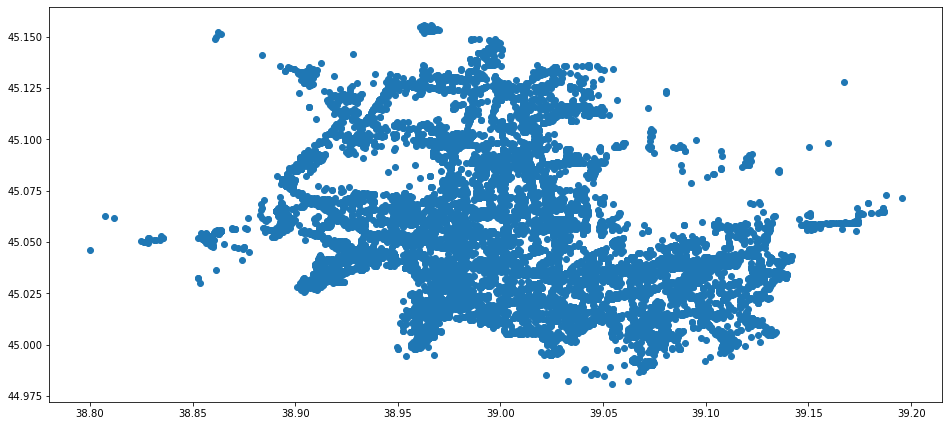

In [388]:
gdf.plot(figsize = (16, 15))

## Статистика

Топ-20 по отзывам

In [379]:
gdf.sort_values('user_ratings_total', ascending = False)[:20]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
1597,https://www.google.com/maps/place/?q=place_id:...,Парк «Краснодар»,"Краснодар, Краснодарский край, 350059",Парк,"[Загруженность в 04:00: 0%., Загруженность в 0...",POINT (39.03178 45.04164),"['park', 'tourist_attraction', 'point_of_inter...",4.9,35831.0
1604,https://www.google.com/maps/place/?q=place_id:...,"Стадион ФК ""Краснодар""","ул. Разведчика Леонова, 1, Краснодар, Краснода...",Стадион,NaN,POINT (39.02919 45.04449),"['stadium', 'gym', 'health', 'point_of_interes...",4.9,25865.0
8009,https://www.google.com/maps/place/?q=place_id:...,Бауцентр,"ул. Ростовское ш., 28 корпус 7, Краснодар, Кра...",Магазин строительных товаров,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (38.99397 45.09639),"['hardware_store', 'park', 'point_of_interest'...",4.5,12139.0
13916,https://www.google.com/maps/place/?q=place_id:...,Гипер Лента,"ул. Российская, 257, Краснодар, Краснодарский ...",Гипермаркет,"[Загруженность в 04:00: 1%., Загруженность в 0...",POINT (39.01224 45.08723),"['supermarket', 'grocery_or_supermarket', 'foo...",4.3,11592.0
10675,https://www.google.com/maps/place/?q=place_id:...,Лента,"ул. Восточный обход, 19, Краснодар, Краснодарс...",Гипермаркет,"[Загруженность в 04:00: 1%., Загруженность в 0...",POINT (39.12662 45.03775),"['supermarket', 'grocery_or_supermarket', 'foo...",4.4,7836.0
2728,https://www.google.com/maps/place/?q=place_id:...,Солнечный остров,"Краснодар, Краснодарский край, 350002",Парк развлечений,"[Загруженность в 04:00: 1%., Загруженность в 0...",POINT (39.05438 45.00731),"['amusement_park', 'tourist_attraction', 'poin...",4.6,7730.0
11792,https://www.google.com/maps/place/?q=place_id:...,Бауцентр,"ул. Селезнева, 4, Краснодар, Краснодарский кра...",Магазин строительных товаров,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (39.02041 45.02747),"['park', 'point_of_interest', 'store', 'establ...",4.4,7462.0
240,https://www.google.com/maps/place/?q=place_id:...,"Городской сад, парк культуры и отдыха","ул. Постовая, 34, Краснодар, Краснодарский кра...",Парк,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (38.96992 45.01055),"['park', 'tourist_attraction', 'point_of_inter...",4.6,6826.0
11148,https://www.google.com/maps/place/?q=place_id:...,Лента,"ул. Западный обход, 29, Краснодар, Краснодарск...",Гипермаркет,"[Загруженность в 04:00: 0%., Загруженность в 0...",POINT (38.89383 45.08038),"['supermarket', 'grocery_or_supermarket', 'foo...",4.4,6735.0
3597,https://www.google.com/maps/place/?q=place_id:...,Декатлон,"Крылатая улица 2 ТРК «OZ», Краснодар, Краснода...",Магазин спортивной одежды,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (39.12314 45.01267),"['point_of_interest', 'clothing_store', 'store...",4.6,5768.0


Поиск обязательных аттракторов: 

Присутствуют:
+ Парк Краснодар (Галицкого) 	Близко к району проектирования, современный парк, - нельзя с собаками
+ Парк Солнечный остров	Требует ухода, есть пляж, проблема с вывозом мусора
+ Сафари-парк	Зоопарк на территории с солнечного острова, запущенный
+ Парк 30-летия Победы	Военный музей, набережная реки Кубань
+ Парк Рождественский	Место «пикников», неблагоустроенный 
+ Старая Кубань	Пляж, грязный, грязная река
+ Сквер Дружбы	Ухоженный сквер в центре, многолюдный

Отсутствуют:
- Ботанический сад им. профессора И. С. Косенко Ухоженный, уютный
- Чистяковская роща	Много зелени, несколько запущенный 
- Городской сад	Исторический парк, проблемы с аттракционом
- Сквер им. Маршала Г.К. Жукова	Маленький уютный сквер, напротив администрации
- Городской сад	Парк в начале Красной улицы, нравится горожанам
- Учебный Ботанический Сад	Иногда открыт только для экскурсий

In [408]:
gdf.loc[gdf.title.str.contains('Ботанический')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total


Можно выделить доп категории: магазин, здоровье, машины, еда, школа, услуги

In [380]:
gdf['types'].apply(lambda s: list(ast.literal_eval(s))).explode().str.split('_').explode().value_counts()[:20]

of               15193
point            15170
interest         15170
establishment    15170
store             5876
health            1051
car               1025
food              1000
contractor         867
general            848
repair             827
home               741
goods              723
finance            556
lodging            440
supermarket        426
school             381
agency             373
salon              343
beauty             343
Name: types, dtype: int64

Магазины

In [350]:
gdf.loc[(gdf.title.str.lower().str.contains('магазин'))|(gdf.category.str.lower().str.contains('магазин')) |(gdf.types.str.contains('store'))]

,url,title,address,category,popular_times_bars,reviews_hist,geometry,types,rating,user_ratings_total
3,https://www.google.com/maps/place/?q=place_id:...,Магнит,"ул. Уральская, 184/2, Краснодар, Краснодарский...",Продовольственный магазин,"[Загруженность в 06:00: 0%., Загруженность в 0...",NaN,POINT (39.10433 45.04238),"['grocery_or_supermarket', 'food', 'point_of_i...",4.2,237.0
4,https://www.google.com/maps/place/?q=place_id:...,MOHITO,"Крылатая ул., 2, Краснодар, Краснодарский край...",Магазин женской одежды,NaN,NaN,POINT (39.12202 45.01224),"['point_of_interest', 'clothing_store', 'store...",4.7,13.0
5,https://www.google.com/maps/place/?q=place_id:...,Здоровый Мир,"ул. Захарова, 25, Краснодар, Краснодарский кра...",Аптека,NaN,NaN,POINT (38.96666 45.00617),"['pharmacy', 'health', 'point_of_interest', 's...",5.0,2.0
11,https://www.google.com/maps/place/?q=place_id:...,Westland,"Крылатая ул., 2, Краснодар, Краснодарский край...",Магазин джинсовой одежды,NaN,NaN,POINT (39.12190 45.01214),"['point_of_interest', 'clothing_store', 'store...",4.5,8.0
19,https://www.google.com/maps/place/?q=place_id:...,Сладкий Домик,"ТЦ ""ОZ МОЛЛ"", Крылатая ул., 2, Краснодар, Крас...",Кондитерский магазин,NaN,NaN,POINT (39.12269 45.01250),"['food', 'point_of_interest', 'store', 'establ...",4.0,2.0
...,...,...,...,...,...,...,...,...,...,...
14834,https://www.google.com/maps/place/?q=place_id:...,Магазин автозапчастей UMR-AUTO.RU,"ул. 70-летия Октября, 12, Краснодар, Краснодар...",Автомастерская,NaN,NaN,POINT (38.90284 45.03020),"['car_repair', 'point_of_interest', 'store', '...",NaN,NaN
14836,https://www.google.com/maps/place/?q=place_id:...,Восточные сладости,"ул. Восточно-Кругликовская, 26, Краснодар, Кра...",Кондитерский магазин,"[Загруженность в : %., Загруженность в 06:00: ...",NaN,POINT (39.02806 45.04899),"['food', 'point_of_interest', 'store', 'establ...",4.8,12.0
14838,https://www.google.com/maps/place/?q=place_id:...,Ветеринарная клиника Альфа,"Ореховая (ст Рассвет), 225, 1 этаж пос, Знамен...",Ветеринарная клиника,"[Загруженность в 06:00: 0%., Загруженность в 0...",NaN,POINT (39.15967 45.05893),"['pharmacy', 'pet_store', 'veterinary_care', '...",4.4,20.0
14840,https://www.google.com/maps/place/?q=place_id:...,"ИМПЕРИЯ СТИЛЯ, салон штор","ул. Восточно-Кругликовская, 26, Краснодар, Кра...",Магазин штор,NaN,NaN,POINT (39.02802 45.04902),"['home_goods_store', 'point_of_interest', 'sto...",NaN,NaN


Здоровье

In [351]:
gdf.loc[gdf.types.str.contains('health')]

,url,title,address,category,popular_times_bars,reviews_hist,geometry,types,rating,user_ratings_total
5,https://www.google.com/maps/place/?q=place_id:...,Здоровый Мир,"ул. Захарова, 25, Краснодар, Краснодарский кра...",Аптека,NaN,NaN,POINT (38.96666 45.00617),"['pharmacy', 'health', 'point_of_interest', 's...",5.0,2.0
12,https://www.google.com/maps/place/?q=place_id:...,Медицинская лаборатория CL,"ул. Уральская, 166/2, Краснодар, Краснодарский...",Медицинская лаборатория,NaN,NaN,POINT (39.09605 45.04058),"['health', 'point_of_interest', 'establishment']",3.2,5.0
25,https://www.google.com/maps/place/?q=place_id:...,"Клуб спортивных единоборств ""Комсомолец СПОРТ""","ул. 30 Иркутской Дивизии, 11/2, Краснодар, Кра...",Школа боевых искусств,NaN,NaN,POINT (39.10206 45.03883),"['health', 'point_of_interest', 'establishment']",5.0,13.0
28,https://www.google.com/maps/place/?q=place_id:...,Краевой центр охраны здоровья семьи и репродукции,"площадь Победы, 1, Краснодар, Краснодарский кр...",Центр планирования семьи,NaN,NaN,POINT (38.96894 45.01255),"['health', 'point_of_interest', 'establishment']",4.3,17.0
33,https://www.google.com/maps/place/?q=place_id:...,Отделение Реанимации И Интенсивной Терапии Нов...,"пл. Победы, ул, корпус 1, Краснодар, Краснодар...",Отделение больницы,NaN,NaN,POINT (38.96869 45.01203),"['health', 'point_of_interest', 'establishment']",5.0,1.0
...,...,...,...,...,...,...,...,...,...,...
14793,https://www.google.com/maps/place/?q=place_id:...,"Стоматологическая клиника ""Идеал""","ул. Восточно-Кругликовская, 24, Краснодар, Кра...",Стоматологическая клиника,NaN,NaN,POINT (39.02761 45.04859),"['dentist', 'health', 'point_of_interest', 'es...",5.0,6.0
14798,https://www.google.com/maps/place/?q=place_id:...,Аптечный Склад,"yлица Агрохимическая, 114, Краснодар, Краснода...",Аптека,NaN,NaN,POINT (39.00432 45.08595),"['drugstore', 'pharmacy', 'health', 'point_of_...",3.8,15.0
14837,https://www.google.com/maps/place/?q=place_id:...,"САНДАЛ, парикмахерская","ул. Ставропольская, 159/1, Краснодар, Краснода...",Мужская парикмахерская,NaN,NaN,POINT (38.97848 45.01314),"['hair_care', 'health', 'point_of_interest', '...",5.0,1.0
14838,https://www.google.com/maps/place/?q=place_id:...,Ветеринарная клиника Альфа,"Ореховая (ст Рассвет), 225, 1 этаж пос, Знамен...",Ветеринарная клиника,"[Загруженность в 06:00: 0%., Загруженность в 0...",NaN,POINT (39.15967 45.05893),"['pharmacy', 'pet_store', 'veterinary_care', '...",4.4,20.0


Можем говорить о том, что все спортзалы (gym) относятся к категории здоровья

In [353]:
gdf.loc[gdf.types.str.contains('gym'), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().str.split('_').explode().value_counts()[:20]

gym              109
point            109
of               109
interest         109
establishment    109
health           109
spa               10
bar                4
night              3
club               3
lodging            3
food               2
salon              2
beauty             2
hospital           2
restaurant         2
store              1
stadium            1
hair               1
care               1
Name: types, dtype: int64

Парк

In [354]:
gdf.loc[(gdf.category.str.lower()=='парк')]

,url,title,address,category,popular_times_bars,reviews_hist,geometry,types,rating,user_ratings_total
240,https://www.google.com/maps/place/?q=place_id:...,"Городской сад, парк культуры и отдыха","ул. Постовая, 34, Краснодар, Краснодарский кра...",Парк,"[Загруженность в 06:00: 0%., Загруженность в 0...",NaN,POINT (38.96992 45.01055),"['park', 'tourist_attraction', 'point_of_inter...",4.6,6826.0
1597,https://www.google.com/maps/place/?q=place_id:...,Парк «Краснодар»,"Краснодар, Краснодарский край, 350059",Парк,"[Загруженность в 04:00: 0%., Загруженность в 0...",NaN,POINT (39.03178 45.04164),"['park', 'tourist_attraction', 'point_of_inter...",4.9,35831.0
1778,https://www.google.com/maps/place/?q=place_id:...,Красный кут,"Краснодар, Краснодарский край, 350011",Парк,"[Загруженность в 04:00: 2%., Загруженность в 0...",NaN,POINT (39.02230 44.98523),"['park', 'tourist_attraction', 'point_of_inter...",4.5,110.0
2751,https://www.google.com/maps/place/?q=place_id:...,"Старая Кубань, городской пляж","ул. Парусная, 4, Краснодар, Краснодарский край...",Парк,"[Загруженность в 04:00: 1%., Загруженность в 0...",NaN,POINT (39.06201 45.00649),"['park', 'point_of_interest', 'establishment']",4.5,776.0
2853,https://www.google.com/maps/place/?q=place_id:...,TreeTopPark,"с, ул. Трамвайная, 2 строение 8, Краснодар, Кр...",Парк,NaN,NaN,POINT (39.05614 45.00754),"['park', 'point_of_interest', 'establishment']",2.7,3.0
2892,https://www.google.com/maps/place/?q=place_id:...,45 параллель,"ул. Трамвайная, 2 строение 8, Краснодар, Красн...",Парк,NaN,NaN,POINT (39.05517 45.00872),"['park', 'point_of_interest', 'establishment']",4.6,10.0
3018,https://www.google.com/maps/place/?q=place_id:...,Пирс,"оз. Старая, Кубань, Краснодарский край, 350058",Парк,"[Загруженность в 04:00: 4%., Загруженность в 0...",NaN,POINT (39.05740 45.00958),"['park', 'point_of_interest', 'establishment']",4.7,112.0
4406,https://www.google.com/maps/place/?q=place_id:...,Парк имени Чуприна,"ул. Советская, 2 корпус 4, Краснодарский край,...",Парк,NaN,NaN,POINT (38.88408 45.06189),"['point_of_interest', 'establishment']",NaN,NaN
6346,https://www.google.com/maps/place/?q=place_id:...,Дамба На Дзержинского,"ул. Сормовская, 198 корпус 2, Краснодар, Красн...",Парк,"[Загруженность в 04:00: 12%., Загруженность в ...",NaN,POINT (39.10427 45.03665),"['park', 'point_of_interest', 'establishment']",4.4,192.0
10610,https://www.google.com/maps/place/?q=place_id:...,Тополинный Дом,"ул. Московская, 111/1, Краснодар, Краснодарски...",Парк,NaN,NaN,POINT (39.00005 45.08879),"['park', 'point_of_interest', 'establishment']",4.2,25.0
